In [1]:
# notebook settings
%load_ext autoreload
%autoreload 2
%matplotlib notebook

# external imports
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

In [2]:
N_sim = 50

In [3]:
e_sigmas = [0., 0.001, 0.003, 0.01]
times_cs = {}
times_ws = {}
times_ws_constr = {}
times_grb = {}
times_grb_fair = {}
for e in e_sigmas:
    times_cs[e] = list(np.load('data/times_cs_sd_{:.3f}.npy'.format(e), allow_pickle=True))
    times_grb[e] = list(np.load('data/times_grb_sd_{:.3f}.npy'.format(e), allow_pickle=True))
    times_ws[e] = [t[1:] for t in np.load('data/times_ws_sd_{:.3f}.npy'.format(e), allow_pickle=True)]
    times_ws_constr[e] = [t[:-1] for t in np.load('data/times_ws_constr_sd_{:.3f}.npy'.format(e), allow_pickle=True)]
#     times_ws[e] = np.array(times_ws[e]) + np.array(times_ws_constr[e])
    
    times_grb_fair[e] = list(np.load('data/times_grb_fair_sd_{:.3f}.npy'.format(e), allow_pickle=True))
#         nodes_ws[e] = np.load('data/nodes_ws_sd_{:.3f}.npy'format(e), allow_pickle=True)[:,1:]
#         len_ws[e] = np.load('data/len_ws_sd_{:.3f}.npy'format(e), allow_pickle=True)[:,:-1]
#     else:
#         nodes_ws[e] = [n[1:] for n in np.load('data/nodes_ws_sd_{:.3f}.npy'format(e), allow_pickle=True)]
#         len_ws[e] = [n[:-1] for n in np.load('data/len_ws_sd_{:.3f}.npy'format(e), allow_pickle=True)]

In [4]:
# remove infeasible trajecotories
for e in e_sigmas:
    times_cs[e] = [t for t in times_cs[e] if len(t) == N_sim]
    times_ws[e] = [t for t in times_ws[e] if len(t) == N_sim-1]
    times_ws_constr[e] = [t for t in times_ws_constr[e] if len(t) == N_sim-1]
    times_grb[e] = [t for t in times_grb[e] if len(t) == N_sim]

for e in e_sigmas:
    times_ws[e] = np.vstack(times_ws[e]) + np.vstack(times_ws_constr[e])

In [5]:
def get_statistics(data, len_data):
    mins = []
    p80 = []
    p90 = []
    maxs = []
    for t in range(len_data):
        n_t = [float(n[t]) for n in data]
        mins.append(min(n_t))
        p80.append(np.percentile(n_t, 80))
        p90.append(np.percentile(n_t, 90))
        maxs.append(max(n_t))
    return mins, p80, p90, maxs

In [6]:
def plot_statistics(ax, data, t0=0, **kwargs):
    mins, p80, p90, maxs = get_statistics(data, N_sim-t0)
    ax.plot(range(t0, N_sim), mins, **kwargs)
    ax.plot(range(t0, N_sim), maxs, **kwargs)
    ax.plot(range(t0, N_sim), p80, linestyle='--', **kwargs)
    ax.plot(range(t0, N_sim), p90, linestyle=':', **kwargs)
    ax.fill_between(range(t0, N_sim), mins, maxs, alpha=.1, **kwargs)

In [7]:
from decimal import Decimal

def fexp(number):
    (sign, digits, exponent) = Decimal(number).as_tuple()
    return len(digits) + exponent - 1

def fman(number):
    return Decimal(number).scaleb(-fexp(number)).normalize()

In [8]:
from math import log10
def tick_format(value, tick_number):
#     return r'$%.2f \ \mathrm{s}$' % value
    return r'$10^{%d} \ \mathrm{s}$' % int(log10(value))

In [9]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 12})

<IPython.core.display.Javascript object>


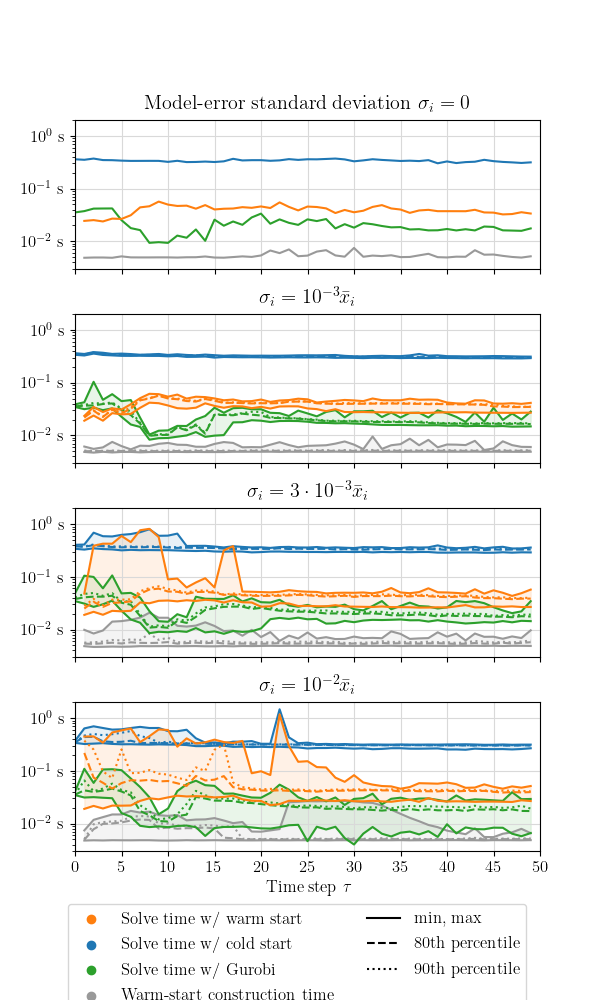

In [17]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(6,10))
gridspec.GridSpec(20,1)

# sizes of the subplots
heights = [2., 2., 2., 2.]
rowspans = [4, 4, 4, 4]
xticks = range(0, N_sim+1, 5)

# nominal case
plt.subplot2grid((20, 1), (0,0), rowspan=rowspans[0], colspan=1)
plt.title(r'Model-error standard deviation $\sigma_i = 0$')
plt.plot(range(1,len(times_ws_constr[0.][0])+1), times_ws_constr[0.][0], color=np.ones(3)*.6)
plt.plot(range(len(times_grb[0.][0])), times_grb[0.][0], color='#2ca02c')
plt.plot(range(len(times_cs[0.][0])), times_cs[0.][0], color='#1f77b4')
plt.plot(range(1,len(times_ws[0.][0])+1), times_ws[0.][0], color='#ff7f0e')
plt.grid(True, color=np.ones(3)*.85)
plt.xlim(0, N_sim)
plt.xticks(xticks, ['']*len(xticks))
plt.yscale('log')
plt.ylim(3e-3, heights[0])
# plt.ylabel(r'Solve time (s)')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(tick_format))


# with disturbances
for i, e in enumerate(e_sigmas[1:]):
    i += 1
    plt.subplot2grid(
        (20, 1),
        (sum(rowspans[:i]) + i,0),
        rowspan=rowspans[i],
        colspan=1
    )
    plot_statistics(plt, times_ws_constr[e], t0=1, color=np.ones(3)*.6)
    plot_statistics(plt, times_grb[e], color='#2ca02c')
    plot_statistics(plt, times_cs[e], color='#1f77b4')
    plot_statistics(plt, times_ws[e], t0=1, color='#ff7f0e')
    plt.grid(True, color=np.ones(3)*.85)
    plt.xlim(0, N_sim)
    plt.yscale('log')
    plt.ylim(3e-3, heights[i])
#     plt.ylabel(r'Solve time (s)')
    plt.xticks(xticks, ['']*len(xticks))
    coef = float(fman(e_sigmas[i]))
    exp = fexp(e_sigmas[i])
    if coef == 1.:
        plt.title(r'$\sigma_i = 10^{%.0f} \bar x_i$'%exp)
    else:
        plt.title(r'$\sigma_i = %.0f \cdot 10^{%.0f} \bar x_i$'%(coef,exp))
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(tick_format))
    
# x axis
plt.xlabel(r'Time step $\tau$')
plt.xticks(xticks, xticks)

# legend
plt.scatter(-10., -10., color='#ff7f0e', label='Solve time w/ warm start')
plt.scatter(-10., -10., color='#1f77b4', label='Solve time w/ cold start')
plt.scatter(-10., -10., color='#2ca02c', label='Solve time w/ Gurobi')
plt.scatter(-10., -10., color=np.ones(3)*.6, label='Warm-start construction time')
plt.plot(-10., -10., color='k', label='min, max')
plt.plot(-10., -10., color='k', linestyle='--', label='80th percentile')
plt.plot(-10., -10., color='k', linestyle=':', label='90th percentile')
handles, labels = plt.gca().get_legend_handles_labels()
order = [3,4,5,6,0,1,2] # 3 columns
# order = [3,4,5,0,1,2] # 3 columns
lgd = plt.legend(
    [handles[i] for i in order],
    [labels[i] for i in order],
    loc='upper center',
    bbox_to_anchor=(0.477, -0.30),
    ncol=2
)

# fig.tight_layout()
fig.savefig('times.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

In [11]:
print(np.min(times_ws[0][0]), np.max(times_ws[0][0]), np.mean(times_ws[0][0]))

0.02376866340637207 0.05658388137817383 0.039515597479684014


In [12]:
print(np.min(times_cs[0][0]), np.max(times_cs[0][0]), np.mean(times_cs[0][0]))

0.3017551898956299 0.37088537216186523 0.33823256969451904


In [13]:
print(np.min(times_grb[0][0]), np.max(times_grb[0][0]), np.mean(times_grb[0][0]))

0.009313106536865234 0.04197120666503906 0.02093776226043701


In [14]:
print(np.min(times_grb_fair[0][0]), np.max(times_grb_fair[0][0]), np.mean(times_grb_fair[0][0]))

0.027524948120117188 0.3363668918609619 0.06275383472442626
